## Transformer

Epoch 1/100


C:\Users\tnv59\AppData\Local\anaconda3\envs\my_open\lib\site-packages\keras\backend.py:5586: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits, "Softmax", "sparse_categorical_crossentropy"


391/391 [==============================] - 128s 317ms/step - loss: 1.8725 - accuracy: 0.3582 - val_loss: 1.3917 - val_accuracy: 0.5025
Epoch 2/100
391/391 [==============================] - 124s 317ms/step - loss: 1.4535 - accuracy: 0.4727 - val_loss: 1.2143 - val_accuracy: 0.5587
Epoch 3/100
391/391 [==============================] - 132s 337ms/step - loss: 1.3136 - accuracy: 0.5271 - val_loss: 1.1662 - val_accuracy: 0.5824
Epoch 4/100
391/391 [==============================] - 137s 350ms/step - loss: 1.2030 - accuracy: 0.5692 - val_loss: 1.0645 - val_accuracy: 0.6199
Epoch 5/100
391/391 [==============================] - 134s 342ms/step - loss: 1.1240 - accuracy: 0.6012 - val_loss: 1.0075 - val_accuracy: 0.6455
Epoch 6/100
391/391 [==============================] - 138s 354ms/step - loss: 1.0566 - accuracy: 0.6225 - val_loss: 0.9867 - val_accuracy: 0.6499
Epoch 7/100
391/391 [==============================] - 138s 352ms/step - loss: 0.9900 - accuracy: 0.6462 - val_loss: 0.9532 - val_

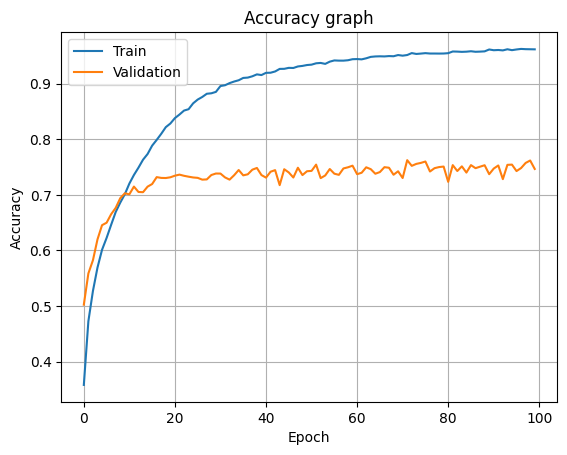

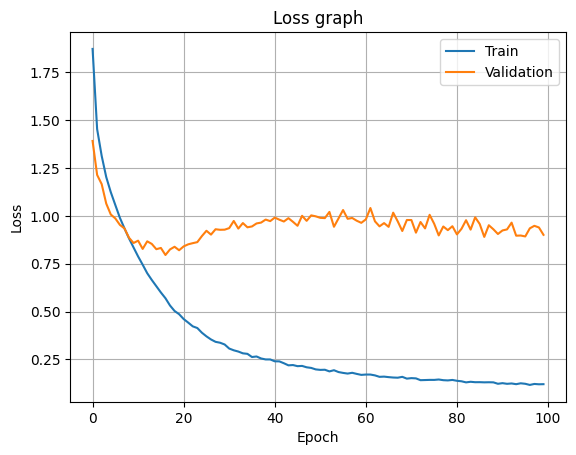

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

(x_train,y_train),(x_test,y_test)=keras.datasets.cifar10.load_data()

n_class=10                      # 부류 수
img_siz=(32,32,3)               # 영상의 크기

patch_siz=4                     # 패치 크기
p2=(img_siz[0]//patch_siz)**2   # 패치 개수
d_model=64                      # 임베딩 벡터 차원
h=8                             # 헤드 개수
N=6                             # 인코더 블록의 개수

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.p_siz=patch_size

    def call(self, img):
        batch_size=tf.shape(img)[0]
        patches=tf.image.extract_patches(images=img,sizes=[1,self.p_siz,self.p_siz,1],strides=[1,self.p_siz,self.p_siz,1],rates=[1,1,1,1],padding="VALID")
        patch_dims=patches.shape[-1]
        patches=tf.reshape(patches,[batch_size,-1,patch_dims])
        return patches

class PatchEncoder(layers.Layer):
    def __init__(self,p2,d_model): # p2: 패치 개수
        super(PatchEncoder,self).__init__()
        self.p2=p2
        self.projection=layers.Dense(units=d_model)
        self.position_embedding=layers.Embedding(input_dim=p2,output_dim=d_model)

    def call(self,patch):
        positions=tf.range(start=0,limit=self.p2,delta=1)
        encoded=self.projection(patch)+self.position_embedding(positions)
        return encoded

def create_vit_classifier():
    input=layers.Input(shape=(img_siz))
    nor=layers.Normalization()(input)
    
    patches=Patches(patch_siz)(nor)	# 패치 생성
    x=PatchEncoder(p2,d_model)(patches)	# 패치 인코딩

    for _ in range(N):			# 다중 인코더 블록
        x1=layers.LayerNormalization(epsilon=1e-6)(x)		# 층 정규화
        x2=layers.MultiHeadAttention(num_heads=h,key_dim=d_model//h,dropout=0.1)(x1,x1)			# MHA
        x3=layers.Add()([x2,x])		# 지름길 연결
        x4=layers.LayerNormalization(epsilon=1e-6)(x3)	# 층 정규화
        x5=layers.Dense(d_model*2,activation=tf.nn.gelu)(x4)
        x6=layers.Dropout(0.1)(x5)
        x7=layers.Dense(d_model,activation=tf.nn.gelu)(x6)   
        x8=layers.Dropout(0.1)(x7)        
        x=layers.Add()([x8,x3])		# 지름길 연결
    
        x=layers.LayerNormalization(epsilon=1e-6)(x)
        x=layers.Flatten()(x)
        x=layers.Dropout(0.5)(x)   
        x=layers.Dense(2048,activation=tf.nn.gelu)(x)    
        x=layers.Dropout(0.5)(x)
        x=layers.Dense(1024,activation=tf.nn.gelu)(x)    
        x=layers.Dropout(0.5)(x)    
        output=layers.Dense(n_class,activation='softmax')(x)
        
        model=keras.Model(inputs=input,outputs=output)
        return model

model=create_vit_classifier()
model.layers[1].adapt(x_train)

model.compile(optimizer=Adam(),loss=SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
hist=model.fit(x_train,y_train,batch_size=128,epochs=100,validation_data=(x_test,y_test),verbose=1)

res=model.evaluate(x_test,y_test,verbose=0)
print('정확률=',res[1]*100)

import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Accuracy graph')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'])
plt.grid()
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss graph')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'])
plt.grid()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
import os

(x_train,y_train),(x_test,y_test)=keras.datasets.cifar10.load_data()

n_class=10			# 부류 수
img_siz=(32,32,3)
img_expanded_siz=(72,72,3)

patch_siz=6			# 패치 크기
p2=(img_expanded_siz[0]//patch_siz)**2 # 패치 개수
d_model=64			# 임베딩 벡터 차원
h=8				# 헤드 개수
N=6				# 인코더 블록의 개수

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.p_siz=patch_size

    def call(self, img):
        batch_size=tf.shape(img)[0]
        patches=tf.image.extract_patches(images=img,sizes=[1,self.p_siz,self.p_siz,1],strides=[1,self.p_siz,self.p_siz,1],rates=[1,1,1,1],padding="VALID")
        patch_dims=patches.shape[-1]
        patches=tf.reshape(patches,[batch_size,-1,patch_dims])
        return patches

class PatchEncoder(layers.Layer):
    def __init__(self,p2,d_model): # p2: 패치 개수
        super(PatchEncoder,self).__init__()
        self.p2=p2
        self.projection=layers.Dense(units=d_model)
        self.position_embedding=layers.Embedding(input_dim=p2,output_dim=d_model)

    def call(self,patch):
        positions=tf.range(start=0,limit=self.p2,delta=1)
        encoded=self.projection(patch)+self.position_embedding(positions)
        return encoded
    
def create_vit_classifier():
    input=layers.Input(shape=(img_siz))
    nor=layers.Normalization()(input)
    exp=layers.Resizing(img_expanded_siz[0],img_expanded_siz[1])(nor)
    
    x=layers.RandomFlip('horizontal')(exp)
    x=layers.RandomRotation(factor=0.02)(x)
    x=layers.RandomZoom(height_factor=0.2, width_factor=0.2)(x)
    
    patches=Patches(patch_siz)(x)		# 패치 생성
    x=PatchEncoder(p2,d_model)(patches)	# 패치 인코딩

    for _ in range(N):			# 다중 인코더 블록
        x1=layers.LayerNormalization(epsilon=1e-6)(x)		# 층 정규화
        x2=layers.MultiHeadAttention(num_heads=h,key_dim=d_model//h,dropout=0.1)(x1,x1)			# MHA
        x3=layers.Add()([x2,x])		# 지름길 연결
        x4=layers.LayerNormalization(epsilon=1e-6)(x3)	# 층 정규화
        x5=layers.Dense(d_model*2,activation=tf.nn.gelu)(x4)
        x6=layers.Dropout(0.1)(x5)
        x7=layers.Dense(d_model,activation=tf.nn.gelu)(x6)   
        x8=layers.Dropout(0.1)(x7)        
        x=layers.Add()([x8,x3])		# 지름길 연결
    
        x=layers.LayerNormalization(epsilon=1e-6)(x)
        x=layers.Flatten()(x)
        x=layers.Dropout(0.5)(x)   
        x=layers.Dense(2048,activation=tf.nn.gelu)(x)    
        x=layers.Dropout(0.5)(x)
        x=layers.Dense(1024,activation=tf.nn.gelu)(x)    
        x=layers.Dropout(0.5)(x)    
        output=layers.Dense(n_class,activation='softmax')(x)
        
        model=keras.Model(inputs=input,outputs=output)
        return model

checkpoint_path = "C:/Users/tnv59/my_open/.ipynb_checkpoints/epoch_{epoch:03d}.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 period=1, # 1개의 epoch마다 저장
                                                 verbose=1)
    
model=create_vit_classifier()
model.layers[1].adapt(x_train)

model.compile(optimizer=Adam(),loss=SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
hist=model.fit(x_train,y_train,batch_size=128,epochs=50,validation_data=(x_test,y_test),verbose=1, callbacks = [cp_callback])

res=model.evaluate(x_test,y_test,verbose=0)
print('정확률=',res[1]*100)

import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Accuracy graph')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'])
plt.grid()
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss graph')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'])
plt.grid()
plt.show()

Epoch 1/50


C:\Users\tnv59\AppData\Local\anaconda3\envs\my_open\lib\site-packages\keras\backend.py:5586: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits, "Softmax", "sparse_categorical_crossentropy"


391/391 [==============================] - ETA: 0s - loss: 1.9892 - accuracy: 0.3360
Epoch 1: saving model to C:/Users/tnv59/my_open/.ipynb_checkpoints\epoch_001.ckpt
391/391 [==============================] - 378s 947ms/step - loss: 1.9892 - accuracy: 0.3360 - val_loss: 1.4377 - val_accuracy: 0.4778
Epoch 2/50
391/391 [==============================] - ETA: 0s - loss: 1.5370 - accuracy: 0.4491
Epoch 2: saving model to C:/Users/tnv59/my_open/.ipynb_checkpoints\epoch_002.ckpt
391/391 [==============================] - 371s 950ms/step - loss: 1.5370 - accuracy: 0.4491 - val_loss: 1.2857 - val_accuracy: 0.5323
Epoch 3/50
391/391 [==============================] - ETA: 0s - loss: 1.4158 - accuracy: 0.4938
Epoch 3: saving model to C:/Users/tnv59/my_open/.ipynb_checkpoints\epoch_003.ckpt
391/391 [==============================] - 372s 951ms/step - loss: 1.4158 - accuracy: 0.4938 - val_loss: 1.1615 - val_accuracy: 0.5817
Epoch 4/50
391/391 [==============================] - ETA: 0s - loss: 1.

Epoch 22/50
391/391 [==============================] - ETA: 0s - loss: 0.7205 - accuracy: 0.7469
Epoch 22: saving model to C:/Users/tnv59/my_open/.ipynb_checkpoints\epoch_022.ckpt
391/391 [==============================] - 391s 1000ms/step - loss: 0.7205 - accuracy: 0.7469 - val_loss: 0.7199 - val_accuracy: 0.7478
Epoch 23/50
391/391 [==============================] - ETA: 0s - loss: 0.7005 - accuracy: 0.7540
Epoch 23: saving model to C:/Users/tnv59/my_open/.ipynb_checkpoints\epoch_023.ckpt
391/391 [==============================] - 391s 1s/step - loss: 0.7005 - accuracy: 0.7540 - val_loss: 0.7028 - val_accuracy: 0.7519
Epoch 24/50
391/391 [==============================] - ETA: 0s - loss: 0.6770 - accuracy: 0.7629
Epoch 24: saving model to C:/Users/tnv59/my_open/.ipynb_checkpoints\epoch_024.ckpt
391/391 [==============================] - 392s 1s/step - loss: 0.6770 - accuracy: 0.7629 - val_loss: 0.7216 - val_accuracy: 0.7478
Epoch 25/50
391/391 [==============================] - ETA: 

In [1]:
!pip install transformers

C:\Users\tnv59\AppData\Local\anaconda3\envs\my_open\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\tnv59\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
C:\Users\tnv59\AppData\Local\anaconda3\envs\my_open\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:31

All PyTorch model weights were used when initializing TFViTForImageClassification.

All the weights of TFViTForImageClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.


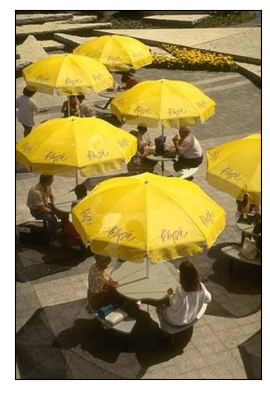

0 번째 영상의 1순위 부류:  umbrella 98.75843048095703


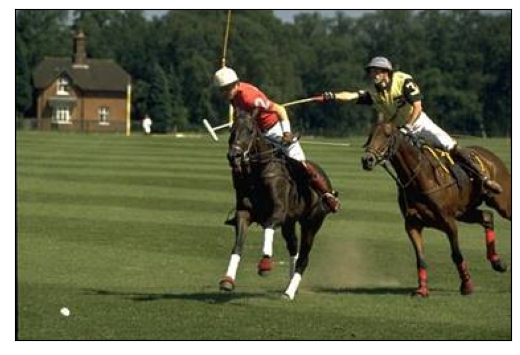

1 번째 영상의 1순위 부류:  croquet ball 3.895780563354492


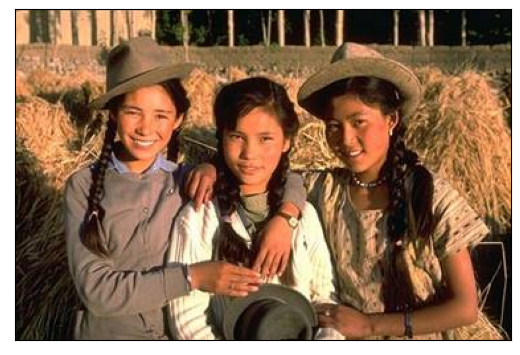

2 번째 영상의 1순위 부류:  hay 18.506418228149414


In [3]:
from transformers import ViTFeatureExtractor, TFViTForImageClassification
from PIL import Image

img=[Image.open('BSDS_242078.jpg'),Image.open('BSDS_361010.jpg'),Image.open('BSDS_376001.jpg')]

feature_extractor=ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model=TFViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

inputs=feature_extractor(img,return_tensors='tf')
res=model(**inputs)

import tensorflow as tf
import matplotlib.pyplot as plt

for i in range(res.logits.shape[0]):
    plt.imshow(img[i]); plt.xticks([]); plt.yticks([]); plt.show()
    predicted_label=int(tf.math.argmax(res.logits[i],axis=-1))
    prob=float(tf.nn.softmax(res.logits[i])[predicted_label]*100.0)
    print(i,'번째 영상의 1순위 부류: ',model.config.id2label[predicted_label],prob)

In [3]:
!pip install opencv-python

     --------------------------------------- 38.6/38.6 MB 40.9 MB/s eta 0:00:00


In [4]:
from transformers import DetrFeatureExtractor, DetrForObjectDetection
from PIL import Image

img=Image.open('BSDS_361010.jpg')

feature_extractor=DetrFeatureExtractor.from_pretrained('facebook/detr-resnet-50')
model=DetrForObjectDetection.from_pretrained('facebook/detr-resnet-50')

inputs=feature_extractor(img,return_tensors='pt')
res=model(**inputs)

import numpy as np
import cv2 as cv

colors=np.random.uniform(0,255,size=(100,3))	# 100개 색으로 트랙 구분
im=cv.cvtColor(np.array(img),cv.COLOR_BGR2RGB)
for i in range(res.logits.shape[1]):
    predicted_label=res.logits[0,i].argmax(-1).item() 
    if predicted_label!=91:
        name=model.config.id2label[predicted_label]
        prob='{:.2f}'.format(float(res.logits[0,i].softmax(dim=0)[predicted_label]))
        cx,cy=int(481*res.pred_boxes[0,i,0]),int(321*res.pred_boxes[0,i,1])
        w,h=int(481*res.pred_boxes[0,i,2]),int(321*res.pred_boxes[0,i,3])
        cv.rectangle(im,(cx-w//2,cy-h//2),(cx+w//2,cy+h//2),colors[predicted_label],2)
        cv.putText(im,name+str(prob),(cx-w//2,cy-h//2-5),cv.FONT_HERSHEY_SIMPLEX,0.6,colors[predicted_label],1)

cv.imshow('DETR',im)
cv.waitKey()       
cv.destroyAllWindows()

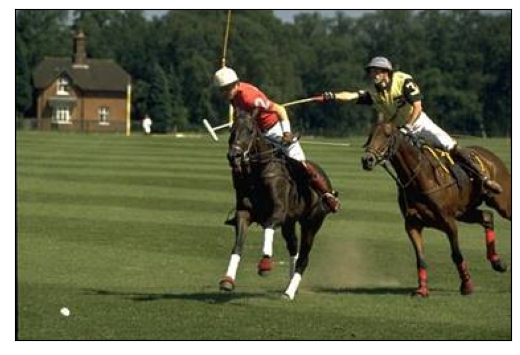

Two horses are running on grass :  10.13
Students are eating :  0.00
Croquet playing on horses :  51.64
Golf playing on horses :  38.24


In [5]:
from transformers import CLIPProcessor, CLIPModel
from PIL import Image

img=Image.open('BSDS_361010.jpg')

processor=CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')
model=CLIPModel.from_pretrained('openai/clip-vit-base-patch32')

captions=['Two horses are running on grass', 'Students are eating', 'Croquet playing on horses', 'Golf playing on horses']
inputs=processor(text=captions,images=img,return_tensors='pt',padding=True)
res=model(**inputs)

import matplotlib.pyplot as plt
plt.imshow(img); plt.xticks([]); plt.yticks([]); plt.show()

logits=res.logits_per_image
probs=logits.softmax(dim=1)
for i in range(len(captions)):
    print(captions[i],': ','{:.2f}'.format(float(probs[0,i]*100.0)))